In [1]:
import numpy as np
import matplotlib.pyplot as plt

### Time constants $\tau_x$ and steady state values $x_{\infty}$ behavior
\begin{align}
    \nonumber \frac{dx}{dt} & = (\alpha_x (1-x) - \beta_x x)k\\ 
    \nonumber & = (\alpha_x - x (\alpha_x + \beta_x))k \\
    & = \underbrace{k (\alpha_x + \beta_x)}_{\frac{1}{\tau_x}}
    (\underbrace{\frac{\alpha_x}{\alpha_x + \beta_x}}_{x_{\infty}} - x)
\end{align}

$x \in \{m, n, h\}$ is either of the neuronal channels

n: potassium channel activation

m:  sodium channel activation

h:  sodium channel inactivation

In [2]:
# Definition of a helper function for visualisation
def plot(function, label):
    V = np.linspace(-100, 100, 100) 
    values = function(V)

    plt.xlim(-100, 100)
    plt.xlabel('V(mV)', fontsize=fontsize)
    plt.ylabel('P', fontsize=fontsize)
    plt.xticks(np.arange(V[0], V[-1]+1, step=50), fontsize=fontsize)
    plt.yticks(np.arange(0,np.max(values)+1, step=1), fontsize=fontsize)
    
    plt.plot(V, values, label=label)
    plt.legend(loc='upper left', fontsize=fontsize)

In [3]:
alpha_m = lambda V: (2.5 - 0.1 * V) / (np.exp(2.5 - 0.1 * V) - 1)
alpha_n = lambda V: (0.1 - 0.01 * V) / (np.exp(1 - 0.1 * V) - 1)
alpha_h = lambda V: 0.07 * np.exp(-V / 20)

beta_m = lambda V: 4 * np.exp(-V / 18)
beta_n = lambda V: 0.125 * np.exp(-V / 80)
beta_h = lambda V: 1 / (np.exp(3 - 0.1 * V) + 1)

k = lambda T: 3 ** (0.1 * (T - 6.3))

x_m = lambda x, V: (alpha_m * (1 - x) - beta_m * x) * k
x_n = lambda x, V: (alpha_n * (1 - x) - beta_n * x) * k
x_h = lambda x, V: (alpha_h * (1 - x) - beta_h * x) * k

##### Plotting time constants evolution

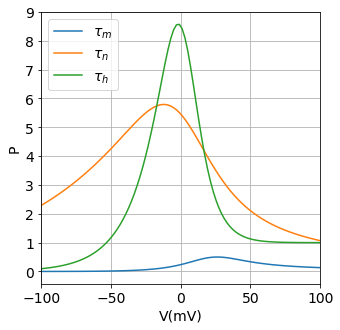

In [5]:
plt.figure(figsize=(5,5))
plt.grid(True)
fontsize = 14

tau_m = lambda V: (k(6.3) * (alpha_m(V) + beta_m(V))) ** -1
plot(tau_m, r'$\tau_m$')

tau_n = lambda V: (k(6.3) * (alpha_n(V) + beta_n(V))) ** -1
plot(tau_n, r'$\tau_n$')

tau_h = lambda V: (k(6.3) * (alpha_h(V) + beta_h(V))) ** -1
plot(tau_h, r'$\tau_h$')

plt.show()

##### Plotting steady state values evolution

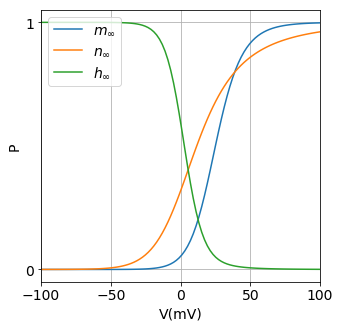

In [6]:
plt.figure(figsize=(5,5))
plt.grid(True)

x_inf_m = lambda V: alpha_m(V) / (alpha_m(V) + beta_m(V))
plot(x_inf_m, r'$m_{\infty}$')

x_inf_n = lambda V: alpha_n(V) / (alpha_n(V) + beta_n(V))
plot(x_inf_n, r'$n_{\infty}$')

x_inf_h = lambda V: alpha_h(V) / (alpha_h(V) + beta_h(V))
plot(x_inf_h, r'$h_{\infty}$')

plt.show()

### Hodgkin - Huxley model

\begin{equation}
    \frac{dV}{dt} = \frac{1}{c} (- i_{ion} + i_{stimulus}) 
\end{equation}
\begin{equation}
    i_{ion} = i_{Na} + i_{K} + i_{L} 
\end{equation}

n: potassium channel activation

m:  sodium channel activation

h:  sodium channel inactivation

$i_{Na} = g_{Na} m^3 h (V - V_{Na})$

$i_{K} = g_{K} n^4 (V - V_{K}) $

$i_{L} = g_{L} (V - V_{L}) $

##### Declaring constant values

In [6]:
# Conductances in ms
G_NA = 120
G_K = 36
G_L = 0.3

# Nernst/Resting potentials in mV
V_NA = 115
V_K = -12
V_L = 10.6

V_REST = 0

c = 1
func = lambda I_total: I_total / c

##### Numerical solvers for differential equations

In [ ]:
def calculateForwardEulerHH(func, V, x, dt):
    return V + dt * func(x)

def calculateExponentialEulerSimple(A, B, X, dt):
    # Initialization
    Y = np.zeros(len(X))
    
    # Iteration
    for t in range(len(Y)):
        Y[t] = X[t] * np.exp(A[t] * dt) + B[t] / A[t] * (np.exp(A[t] * dt) - 1)
    return Y

In [ ]:
def hh_current(V, last_gates, dt, temperature):
    """
    @param dt  is the timestep used for approximation
    @param V   is the membrane potential from the previous time step
    @param last_gates contains the gating variables of the previous time step
    """
    alpha = np.array([alpha_m(V), alpha_n(V), alpha_h(V)])
    beta = np.array([beta_m(V), beta_n(V), beta_h(V)])
    
    A = -(alpha + beta) * k(temperature)
    B = alpha * k(temperature)
    
    [m, n, h] = calculateExponentialEulerSimple(A, B, last_gates, dt)

    iNa = G_NA * m**3 * h * (V - V_NA)
    iK  = G_K * n**4 * (V - V_K)
    iL  = G_L * (V - V_L)

    return [iNa, iK, iL], [m, n, h]

In [7]:
def hh_model(times, i_stim, dt, temperature):
    # Initialization
    V = V_REST
    
    membrane_voltages = [V]
    gates = [[x_inf_m(V), x_inf_n(V), x_inf_h(V)]]
    ion_currents = [[0, 0, 0]]
    
    # Iteration
    for t in range(len(times)-1):
        i_ion, gates_t = hh_current(V, gates[-1], dt, temperature)
        i_total = -np.sum(i_ion) + i_stim[t]
        
        V = calculateForwardEulerHH(func, V, i_total, dt)
        
        membrane_voltages.append(V)
        gates.append(gates_t)
        ion_currents.append(i_ion)
        
    return np.array(membrane_voltages), np.array(gates), np.array(ion_currents)

##### Input currents
Stimalte the neuron with some pulses

In [8]:
def generateInputCurrent(times, stim_duration, gap_duration, amplitudes):
    current = np.zeros(len(times))
    for i in range(len(amplitudes)):
        t_start = np.where(times >= i * (stim_duration + gap_duration))[0][0]
        t_end = np.where(times >= times[t_start] + stim_duration)[0][0]
        current[t_start:t_end] = amplitudes[i]
    return current

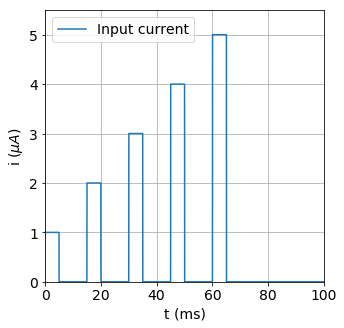

In [10]:
stim_duration = 5
gap_duration = 10

impulses = [1, 2, 3, 4, 5]
t = np.arange(0, 100, 0.01)
i_stimulation = generateInputCurrent(t, stim_duration, gap_duration, impulses)

plt.figure(figsize=(5,5))
plt.grid(True)

plt.xlim(0, 100)
plt.ylim(0, 5.5)
plt.xlabel('t (ms)', fontsize=fontsize)
plt.ylabel('i $(\mu A)$', fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)

plt.plot(t, i_stimulation,  label='Input current')
plt.legend(loc='upper left', fontsize=fontsize)

##### Testing the model

In [11]:
membrane_voltages, gates, ion_currents = hh_model(t, i_stimulation, 0.01, 6.3)

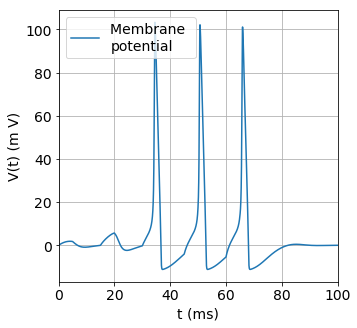

In [12]:
plt.figure(figsize=(5,5))
plt.grid(True)

plt.xlim(0, 100)
plt.xlabel('t (ms)', fontsize=fontsize)
plt.ylabel('V(t) (m V)', fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)

plt.plot(t, membrane_voltages,  label='Membrane \npotential')
plt.legend(loc='upper left', fontsize=fontsize)

##### Plotting the gating variables evolution

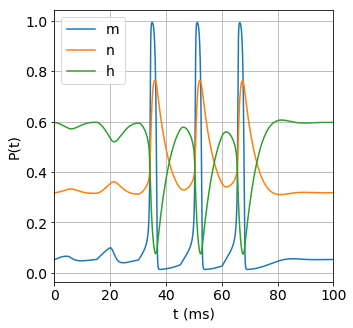

In [13]:
plt.figure(figsize=(5,5))
plt.grid(True)

plt.xlim(0, 100)
plt.xlabel('t (ms)', fontsize=fontsize)
plt.ylabel('P(t)', fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)

plt.plot(t, gates[:,0],  label='m')
plt.plot(t, gates[:,1],  label='n')
plt.plot(t, gates[:,2],  label='h')
plt.legend(loc='upper left', fontsize=fontsize)

##### Plotting currents evolution

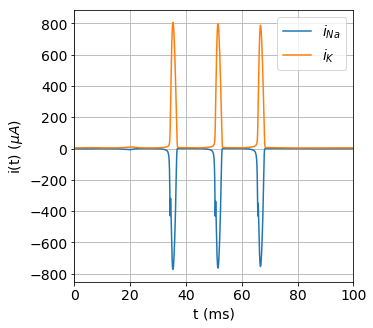

In [14]:
plt.figure(figsize=(5,5))
plt.grid(True)

plt.xlim(0, 100)
plt.xlabel('t (ms)', fontsize=fontsize)
plt.ylabel('i(t) $(\mu A)$', fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)

plt.plot(t, ion_currents[:,0],  label='$i_{Na}$')
plt.plot(t, ion_currents[:,1],  label='$i_{K}$')
plt.legend(loc='upper right', fontsize=fontsize)

##### Phase plot

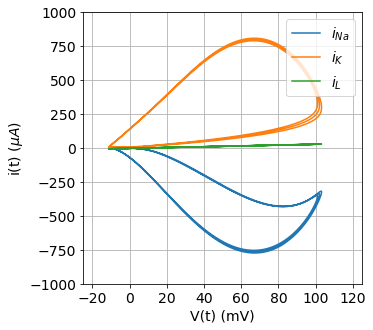

In [15]:
plt.figure(figsize=(5,5))
plt.grid(True)

plt.xlim(-25, 125)
plt.ylim(-1000, 1000)
plt.ylabel('i(t) $(\mu A)$', fontsize=fontsize)
plt.xlabel('V(t) (mV)', fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)

plt.plot(membrane_voltages, ion_currents[:,0],  label='$i_{Na}$')
plt.plot(membrane_voltages, ion_currents[:,1],  label='$i_{K}$')
plt.plot(membrane_voltages, ion_currents[:,2],  label='$i_{L}$')
plt.legend(loc='upper right', fontsize=fontsize)